## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

features:

    - frequency domain:
        - peaks of ppg (in decreasing power order). e.g. first 10 peaks in interval 40-240BPM
        - peaks of accx
        - peaks of accy
        - peaks of accz
        - peaks of acc total (summed frequencys: accx+accy+accz)
        - peaks of acc total (calculated in time domain and then fft)
        - fraction of spectral energy in each 1Hz from 1 to 4 Hz of ppg signal
        - fraction of spectral energy in each 1Hz from 1 to 4 Hz of total acc signal
        
    - time domain:
        - mean of ppg signal (evtl. acc signals)
        - std of ppg signal (evtl. acc signals)
        - evtl. correlations between accx and ppg signal
        - evtl. correlations between accy and ppg signal
        - evtl. correlations between accz and ppg signal
        - evtl. correlations between acc and ppg signal


### Code

In [1]:
import glob
import sys
import numpy as np
import scipy as sp
import pandas as pd
import itertools
import scipy.signal
import scipy.io
import sklearn
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestRegressor
import etl
import plot_util
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

print(f'Python version: {sys.version}')
print(f'Numpy version: {np.__version__}')
print(f'Scipy version: {sp.__version__}')
print(f'sklearn version: {sklearn.__version__}')

Python version: 3.8.5 (default, Aug  5 2020, 03:39:04) 
[Clang 10.0.0 ]
Numpy version: 1.19.1
Scipy version: 1.5.0
sklearn version: 0.23.1


In [2]:
def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates in BPM.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))


def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = etl.LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Infer the pulse rate of a time signal and compare it with the labels ref_fl
    """
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = etl.LoadTroikaDataFile(data_fl)

    # Compute pulse rate estimates and estimation confidence.

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    # How much energy in the frequency spectrum is concentrated near the pulse rate estimate? 
    # You can answer this by summing the frequency spectrum near the pulse rate estimate and dividing it by the sum of the entire spectrum.
    errors, confidence = np.ones(100), np.ones(100)  # Dummy placeholders. Remove
    return errors, confidence

def train_pulse_rate_algorithm():
    return 0



In [3]:
Evaluate()

1.0

In [4]:
def transform_features(dict_features):
    """
    
    """
    features = np.column_stack(list(dict_features.values()))

    # compute feature names:
    feature_names = []
    for key, val in dict_features.items():
        try:
            names = [key] * val.shape[1]
            feature_names += [f'{name}_{i}' for i, name in enumerate(names)]
        except IndexError:
            feature_names += [key]
    return features, feature_names

In [5]:
# not used right now:
# maybe add means and stds to 
# # mean of time signal:
# np.mean(dict_data_raw_window['ppg'], axis=1)
# # std of time signal:
# np.std(dict_data_raw_window['ppg'], axis=1)

# # calculate mean of fft signal in relevant frequency range in vectorized form:
# msk = (dict_data_raw_window['freqs']>=min_freq) & (dict_data_raw_window['freqs']<=max_freq)
# mean = (dict_data_raw_window['fft_ppg'] * msk).sum(axis=1) / msk.sum(axis=1)
# # calculate std of fft signal in relevant frequency range in vectorized form:
# mean_matrix = msk * np.broadcast_to(mean, msk.transpose().shape).transpose()
# std = np.sqrt((((dict_data_raw_window['fft_ppg'] * msk) - mean_matrix)**2).sum(axis=1)/msk.sum(axis=1))


In [6]:
# hyperparameters:
# sampling frequency:
FS = 125
# window sizes in seconds:
WINDOW_LENGTH_SEC = 8
WINDOW_SHIFT_SEC = 2
# transform to data points:
window_length = WINDOW_LENGTH_SEC * FS
window_shift = WINDOW_SHIFT_SEC * FS
BPM_MIN = 40
BPM_MAX = 240
# transform to Hz:
min_freq = BPM_MIN / 60
max_freq = BPM_MAX / 60
# fft window length
# use n>len(time_series) -> we pad the input signal with
# zeros so that we get a higher resolution in frequency space
n_fft = window_length * 4

peaks_param = {
    'ppg': {
        'nr_peaks': 4,
        'height': 0.2,
        'distance': 10,
        'prominence': None,
        'wlen': None,
        'pad_value': -1,
    },
#     'accx': {
#         'nr_peaks': 4,
#         'height': 0.2,
#         'distance': 10,
#         'prominence': None,
#         'wlen': None,
#         'pad_value': -1,
#     },
#     'accy': {
#         'nr_peaks': 4,
#         'height': 0.2,
#         'distance': 10,
#         'prominence': None,
#         'wlen': None,
#         'pad_value': -1,
#     },
#     'accz': {
#         'nr_peaks': 4,
#         'height': 0.2,
#         'distance': 10,
#         'prominence': None,
#         'wlen': None,
#         'pad_value': -1,
#     },
    'acc_abs': {
        'nr_peaks': 4,
        'height': 0.2,
        'distance': 10,
        'prominence': None,
        'wlen': None,
        'pad_value': -1,
    },
#     'acc_sum': {
#         'nr_peaks': 4,
#         'height': 0.2,
#         'distance': 10,
#         'prominence': None,
#         'wlen': None,
#         'pad_value': -1,
#     },
}

frac_en_param = {
    'ppg': {
        'num_intervals': 4,
    },
    'acc_abs': {
        'num_intervals': 4,
    },
#     'acc_sum': {
#         'num_intervals': 4,
#     },
}

In [7]:
%%time
# read data files:
data_files, ref_files = etl.LoadTroikaDataset()
# # print information about imported files
# etl.data_information(
#     file_data=data_files,
#     file_label=ref_files,
#     fs=FS,
#     window_shift_sec=WINDOW_SHIFT_SEC,
#     window_length_sec=WINDOW_LENGTH_SEC
# )
# import raw input data:
input_data_raw = etl.import_input_data(files=data_files)
# import labels:
labels_raw = etl.import_labels(files=ref_files)

# get raw (window) data:
dict_data_raw_window, labels, groups = etl.raw_data(
    input_data_raw=input_data_raw,
    labels_raw=labels_raw,
    window_length=window_length,
    window_shift=window_shift,
    freq_range=(min_freq, max_freq),
    fs=FS,
    n_fft=n_fft)
# get labels in Hz:
labels = labels

CPU times: user 1.12 s, sys: 239 ms, total: 1.36 s
Wall time: 1.43 s


In [8]:
%%time
# get all features:
dict_features = etl.featurize(
    dict_raw_window_data=dict_data_raw_window,
    peaks_param=peaks_param,
    frac_en_param=frac_en_param,
    freq_range=(min_freq, max_freq)
)
features, feature_names = transform_features(dict_features=dict_features)

CPU times: user 1.24 s, sys: 89.6 ms, total: 1.33 s
Wall time: 1.36 s


In [9]:
# number of trees in Random forest:
n_estimators = 100
max_tree_depth = 2

# number of trees in Random forest:
n_estimators_opt = [2, 10, 20, 50, 100, 150, 300]
max_tree_depth_opt = range(2, 7)
n_estimators_opt = [2, 10, 20]
max_tree_depth_opt = range(2, 4)

# initialize cross validation:
# 1 group is left out for validation, the rest is used for training
logo = LeaveOneGroupOut()

In [10]:
# perform nested cross validation:
# to get accurate idea of performance of the ML model, we pick the best
# hyperparameters (based on validation set) on a subset of the data and
# evaluate it on a hold-out-set (test set). This is similar to 
# train-validation-test set split. If dataset is too small to separate
# it into 3 parts, we can nest the hyperparameter selection in another
# layer of cross validation

In [11]:
# features = 
# rest_hparams = 
# hparams = features, ret_hparams


# train valid test split cross validation (leave one group out)
# for train_valid_ind, test_ind in logo.split(X=features, y=labels, groups=groups):
#     X_train_valid, y_train_valid = features[train_valid_ind], labels[train_valid_ind]
#     X_test, y_test = features[test_ind], labels[test_ind]
#     group_test = groups[test_ind][0]


# for hyperparam in hparams:
#     model = define model
    

#         for train_ind, valid_ind in logo.split(X=X_train_valid, y=y_train_valid, groups=groups_train_valid):
#             X_train, y_train = features[train_ind], labels[train_ind]
#             X_valid, y_valid = features[valid_ind], labels[valid_ind]
            
#             model.fit(X_train, y_train)
            
#             model.predict(X_valid)
            
#             errors_valid = []
        
#         mse_valid = mse of all validation sets for the current test set
#         best

In [12]:
# counter for printing iterations:
splits = 0
# iterate over each cross-validation fold (in the first
# iteration the indices of the first group are assigned to test_ind,
# and the remaining indices are asigned to train_valid_ind, in the second
# iteration the indices of the second group are assigned to test_ind,
# and so on):
for train_valid_ind, test_ind in logo.split(X=features, y=labels, groups=groups):
    # split the dataset into a combined training and validation dataset and a
    # test set in this cross-validation fold (the training set has data from
    # only 1 group):
    # training and validation dataset:
    X_train_valid, y_train_valid = features[train_valid_ind], labels[train_valid_ind]
    # testing dataset:
    X_test, y_test = features[test_ind], labels[test_ind]
    # compute new groups array for next (nested) cross validation
    # (training / validation split):
    groups_train_valid = groups[train_valid_ind]
    
    
    ## Model selection on validation set:
    # storage for all evaluation metrics of all hyperparameter sets:
    valid_eval_metrics = []

    hparams_cross_product = itertools.product(n_estimators_opt, max_tree_depth_opt)
    for n_estimators, max_tree_depth in hparams_cross_product:
        # define regressor (ml model) for each set of hyperparameters:
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_tree_depth,
            random_state=42,
            n_jobs=8
        )
        # initialize lists to collect information for evaluation metrics
        valid_score = []
        abs_valid_error = []
        # iterate over each cross-validation fold (in the first
        # iteration the indices of the first group are assigned to valid_ind,
        # and the remaining indices are asigned to train_ind, in the second
        # iteration the indices of the second group are assigned to valid_ind,
        # and so on):
        for train_ind, valid_ind in logo.split(X=X_train_valid, y=y_train_valid, groups=groups_train_valid):
            # split the dataset into training and validation dataset in 
            # this cross-validation fold (the validation set has data from
            # only 1 group):
            X_train, y_train = features[train_ind], labels[train_ind]
            X_valid, y_valid = features[valid_ind], labels[valid_ind]

            # train machine learning model
            # by calling the fit method, the model gets fitted to the current train data
            # if the model has been trained before (on different train data) its saved
            # state (weights/decision paths/etc.) is overwritten:
            model.fit(X_train, y_train)

            # run ml model on the current validation set:
            y_pred_valid = model.predict(X_valid)

            # compute (rolling) scores for model evaluation
            valid_score += [model.score(X=X_valid, y=y_valid)]
            # compute (rolling) basis for calculating MSE and MAE for validation dataset:
            abs_valid_error += [np.abs(y_valid - y_pred_valid)]

        # transform validation scores to numpy array:
        valid_score = np.array(valid_score)
        # compute MAE and MSE for all validation sets with this hyperparameter sets
        # we compute all validation set based metrics over all validation sets (mean, std)
        # so that we get a metric that tells us what hyperparameters work best on the 
        # total dataset that is used for training and validation:
        abs_valid_error = np.concatenate(abs_valid_error)
        mae_valid = np.mean(abs_valid_error)
        mse_valid = np.mean(np.square(abs_valid_error))
        
        # wirte all evaluation metrics (for each hyperparameter set) to a summary list:
        valid_eval_metrics += [(
            n_estimators, max_tree_depth, mse_valid,
            mae_valid, valid_score.mean(),
            valid_score.std()
        )]

    # transform evaluation metric table to pd dataframe:
    df_valid_eval_metrics = pd.DataFrame(
        valid_eval_metrics,
        columns=['n_estimators', 'max_tree_depth', 'mse_valid',
                 'mae_valid', 'valid_score_mean', 'valid_score_std'])

    # create model with best pair of hyperparameters for this training and validation set:
    ser_best_hparams = df_valid_eval_metrics.loc[df_valid_eval_metrics['mae_valid'].argmin(),
                                                 ['n_estimators', 'max_tree_depth', 'mse_valid']]
    print(ser_best_hparams)
    best_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_tree_depth,
        random_state=42,
        n_jobs=8
    )
    best_model.fit(X_train_valid, y_train_valid)
    y_pred_test = best_model.predict(X_test)
    print('test set MAE:')
    mse_test = sklearn.metrics.mean_squared_error(y_true=y_test, y_pred=y_pred_test)
    errors = y_test - y_pred_test
    mae_test = sklearn.metrics.mean_absolute_error(y_true=y_test, y_pred=y_pred_test)
    print(mae_test)
    print()

n_estimators       20.000000
max_tree_depth      3.000000
mse_valid         380.249429
Name: 5, dtype: float64
test set MAE:
16.225361366424945

n_estimators       20.000000
max_tree_depth      3.000000
mse_valid         380.249429
Name: 5, dtype: float64
test set MAE:
16.550650999729147

n_estimators       10.000000
max_tree_depth      3.000000
mse_valid         380.817513
Name: 3, dtype: float64
test set MAE:
11.461701469565783

n_estimators        2.000000
max_tree_depth      3.000000
mse_valid         392.019646
Name: 1, dtype: float64
test set MAE:
16.44868568075092

n_estimators        2.000000
max_tree_depth      3.000000
mse_valid         374.601547
Name: 1, dtype: float64
test set MAE:
17.359095529635663

n_estimators        2.000000
max_tree_depth      3.000000
mse_valid         374.601547
Name: 1, dtype: float64
test set MAE:
14.245308224355531

n_estimators        2.000000
max_tree_depth      3.000000
mse_valid         383.773284
Name: 1, dtype: float64
test set MAE:
13.329

In [21]:
sorted(list(zip(best_model.feature_importances_, feature_names)), reverse=True)

[(0.6096767311598833, 'peaks_pwr_ppg_0'),
 (0.20599595010975585, 'frac_en_int0_ppg'),
 (0.0849719682186563, 'peaks_pwr_acc_abs_0'),
 (0.03565222345302153, 'peaks_freq_ppg_0'),
 (0.03186552990662008, 'frac_en_int2_ppg'),
 (0.01177925794256844, 'frac_en_int1_ppg'),
 (0.007007201547211684, 'peaks_pwr_acc_abs_1'),
 (0.005850044892781108, 'peaks_pwr_ppg_1'),
 (0.0024709436571175077, 'frac_en_int2_acc_abs'),
 (0.002368705189976018, 'frac_en_int1_acc_abs'),
 (0.0019530082125825395, 'peaks_pwr_acc_abs_3'),
 (0.0004084357098258776, 'peaks_freq_acc_abs_0'),
 (0.0, 'peaks_pwr_ppg_3'),
 (0.0, 'peaks_pwr_ppg_2'),
 (0.0, 'peaks_pwr_acc_abs_2'),
 (0.0, 'peaks_freq_ppg_3'),
 (0.0, 'peaks_freq_ppg_2'),
 (0.0, 'peaks_freq_ppg_1'),
 (0.0, 'peaks_freq_acc_abs_3'),
 (0.0, 'peaks_freq_acc_abs_2'),
 (0.0, 'peaks_freq_acc_abs_1'),
 (0.0, 'frac_en_int0_acc_abs')]

In [40]:
def prepare_inference_data(
    data_fl,
    window_length,
    window_shift, 
    freq_range,
    fs,
    n_fft,
    peaks_param,
    frac_en_param
):
    """
    :param data_fl: path to data file (with PPG and accelerometer signals)
    :param window_length: length of the window/filter (in sample units)
    :param window_shift: shift of window for each step/ stride (in sample units)
    :param freq_range: tuple with minimum and maximum frequency.
        The frequencies and fft signals are filterd for frequencies
        in this interval range.
    :param fs: Sampling frequency of imported time series
    :param n_fft:    
    :param peaks_param: dictionary with peak parameters for each signal the peak features
        should be calculated
    :param frac_en_param: dictionary with fractional energy parameter for each siagnal the
        fractional energies should be calculated
    """
    # import 
    ppg, accx, accy, accz = etl.LoadTroikaDataFile(data_fl)
    dict_signals = {
        '_': {
            'ppg': ppg,
            'accx': accx,
            'accy': accy,
            'accz': accz,
        }
    }
    
    data, _, _ = etl.raw_data(
        input_data_raw=dict_signals,
        labels_raw=None,
        window_length=window_length,
        window_shift=window_shift,
        freq_range=freq_range,
        fs=fs,
        n_fft=n_fft
    )
    
    # get all features:
    dict_features = etl.featurize(
        dict_raw_window_data=data,
        peaks_param=peaks_param,
        frac_en_param=frac_en_param,
        freq_range=freq_range
    )
    features, feature_names = transform_features(dict_features=dict_features)
    return features, feature_names


def confidence(freqs, fft, y_pred, confidence_freq_range, freq_range):
    """
    
    """
    # for computing the confidence we filter for frequencies
    # in the range of interest.
    freqs_filtered, fft_filtered = etl.filter_frequencies(
        freqs=freqs,
        fft=fft,
        freq_range=freq_range
    )

    # compute confidence:
    conf = []
    for row_freqs, row_fft, pred in zip(freqs_filtered, fft_filtered, y_pred):
        conf += [
            etl.fractional_spectral_energy(
                freqs=row_freqs,
                fft=row_fft,
                freq_range=(pred/60-0.5*confidence_freq_range,
                            pred/60+0.5*confidence_freq_range)
            )[0]
        ]
    return np.stack(conf)

In [45]:
infer_data, infere_data_names = prepare_inference_data(
    data_fl=data_files[0],
    window_length=window_length,
    window_shift=window_shift,
    freq_range=(min_freq, max_freq),
    fs=FS,
    n_fft=n_fft,
    peaks_param=peaks_param,
    frac_en_param=frac_en_param
)
infer = best_model.predict(infer_data)

In [46]:
err = infer - list(labels_raw.values())[0]

In [55]:
confidence_freq_range = 0.1 * (max_freq - min_freq)

confidence(
    freqs=dict_data_raw_window['freqs'][test_ind],
    fft=dict_data_raw_window['fft_ppg'][test_ind],
    y_pred=y_pred_test,
    confidence_freq_range=confidence_freq_range,
    freq_range=(min_freq, max_freq)
)

array([0.02291098, 0.0108403 , 0.00344253, 0.00897484, 0.01561902,
       0.01585284, 0.01305484, 0.03031916, 0.01994996, 0.029872  ,
       0.0305362 , 0.03095808, 0.0281874 , 0.01424959, 0.00421075,
       0.02431989, 0.03932114, 0.03666193, 0.07770058, 0.09670489,
       0.08712742, 0.06981044, 0.20783357, 0.24586205, 0.04223564,
       0.22982445, 0.22131969, 0.02733609, 0.26866478, 0.28302763,
       0.28836268, 0.29662336, 0.29324833, 0.29545431, 0.3294492 ,
       0.32560087, 0.30650143, 0.24147704, 0.21477862, 0.18845594,
       0.17929746, 0.13300693, 0.051941  , 0.02333304, 0.02457186,
       0.01246664, 0.03715599, 0.04349385, 0.02908321, 0.01899805,
       0.0446177 , 0.04775658, 0.11066763, 0.14643579, 0.14302834,
       0.14029627, 0.17380617, 0.15562828, 0.12486451, 0.1685988 ,
       0.12555532, 0.12127271, 0.09213257, 0.14217303, 0.1218301 ,
       0.11949457, 0.14423633, 0.0970704 , 0.04977518, 0.03576438,
       0.01199249, 0.05315702, 0.05471903, 0.03797085, 0.00741

In [30]:
AggregateErrorMetric(pr_errors=errors, confidence_est=confidence)

13.468912073506898

In [ ]:
%%time


# storage for all evaluation metrics of all hyperparameter sets:
eval_metrics = []

hparams_cross_product = itertools.product(n_estimators_opt, max_tree_depth_opt)
for n_estimators, max_tree_depth in hparams_cross_product:
    # define regressor (ml model) for each set of hyperparameters:
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_tree_depth,
        random_state=42,
        n_jobs=8
    )
    # initialize evaluation metrics for each set of hyperparameters
    valid_score = []
    abs_valid_error = []
    # iterate over each cross-validation fold (in the first
    # iteration the indices of the first group are assigned to valid_ind,
    # and the remaining indices are asigned to train_ind, in the second
    # iteration the indices of the second group are assigned to valid_ind,
    # and so on):
    for train_ind, valid_ind in logo.split(X=features, y=labels, groups=groups):
        # split the dataset into training and validation dataset in 
        # this cross-validation fold (the validation set has data from
        # only 1 group):
        X_train, y_train = features[train_ind], labels[train_ind]
        X_valid, y_valid = features[valid_ind], labels[valid_ind]

        # train machine learning model:
        model.fit(X_train, y_train)

        # run ml model on the validation set:
        y_pred = model.predict(X_valid)

        # compute scores for model evaluation
        valid_score += [model.score(X=X_valid, y=y_valid)]
        # compute basis for calculating MSE and MAE for validation dataset:
        abs_valid_error += [np.abs(y_valid - y_pred)]

    # transform validation scores to numpy array:
    valid_score = np.array(valid_score)
    # compute MAE and MSE:
    abs_valid_error = np.concatenate(abs_valid_error)
    mae_valid = np.mean(abs_valid_error)
    mse_valid = np.mean(np.square(abs_valid_error))
    
    # evaluation metric summary list:
    eval_metrics += [(n_estimators, max_tree_depth, mse_valid,
                      mae_valid, valid_score.mean(),
                      valid_score.std())]
# transform evaluation metric table to pd dataframe:
df_eval_metrics = pd.DataFrame(
    eval_metrics,
    columns=['n_estimators', 'max_tree_depth', 'mse_valid',
             'mae_valid', 'valid_score_mean', 'valid_score_std'])
df_eval_metrics

In [43]:
%%time
# initialize cross validation:
# 1 group is left out for validation, the rest is used for training
logo = LeaveOneGroupOut()

# storage for all evaluation metrics of all hyperparameter sets:
eval_metrics = []

hparams_cross_product = itertools.product(n_estimators_opt, max_tree_depth_opt)
for n_estimators, max_tree_depth in hparams_cross_product:
    # define regressor (ml model) for each set of hyperparameters:
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_tree_depth,
        random_state=42,
        n_jobs=8
    )
    # initialize evaluation metrics for each set of hyperparameters
    valid_score = []
    abs_valid_error = []
    # iterate over each cross-validation fold (in the first
    # iteration the indices of the first group are assigned to valid_ind,
    # and the remaining indices are asigned to train_ind, in the second
    # iteration the indices of the second group are assigned to valid_ind,
    # and so on):
    for train_ind, valid_ind in logo.split(X=features, y=labels, groups=groups):
        # split the dataset into training and validation dataset in 
        # this cross-validation fold (the validation set has data from
        # only 1 group):
        X_train, y_train = features[train_ind], labels[train_ind]
        X_valid, y_valid = features[valid_ind], labels[valid_ind]

        # train machine learning model:
        model.fit(X_train, y_train)

        # run ml model on the validation set:
        y_pred = model.predict(X_valid)

        # compute scores for model evaluation
        valid_score += [model.score(X=X_valid, y=y_valid)]
        # compute basis for calculating MSE and MAE for validation dataset:
        abs_valid_error += [np.abs(y_valid - y_pred)]

    # transform validation scores to numpy array:
    valid_score = np.array(valid_score)
    # compute MAE and MSE:
    abs_valid_error = np.concatenate(abs_valid_error)
    mae_valid = np.mean(abs_valid_error)
    mse_valid = np.mean(np.square(abs_valid_error))
    
    # evaluation metric summary list:
    eval_metrics += [(n_estimators, max_tree_depth, mse_valid,
                      mae_valid, valid_score.mean(),
                      valid_score.std())]
# transform evaluation metric table to pd dataframe:
df_eval_metrics = pd.DataFrame(
    eval_metrics,
    columns=['n_estimators', 'max_tree_depth', 'mse_valid',
             'mae_valid', 'valid_score_mean', 'valid_score_std'])
df_eval_metrics

CPU times: user 5.21 s, sys: 218 ms, total: 5.42 s
Wall time: 2.12 s


,n_estimators,max_tree_depth,mse_valid,mae_valid,valid_score_mean,valid_score_std
0,2,2,0.104419,0.258576,-0.270915,1.239066
1,2,3,0.094683,0.241515,-0.167265,1.200521
2,10,2,0.108791,0.263617,-0.295324,1.203593
3,10,3,0.101813,0.249954,-0.352796,1.624876
4,20,2,0.109021,0.265093,-0.422699,1.608724
5,20,3,0.100952,0.248069,-0.438329,1.969346


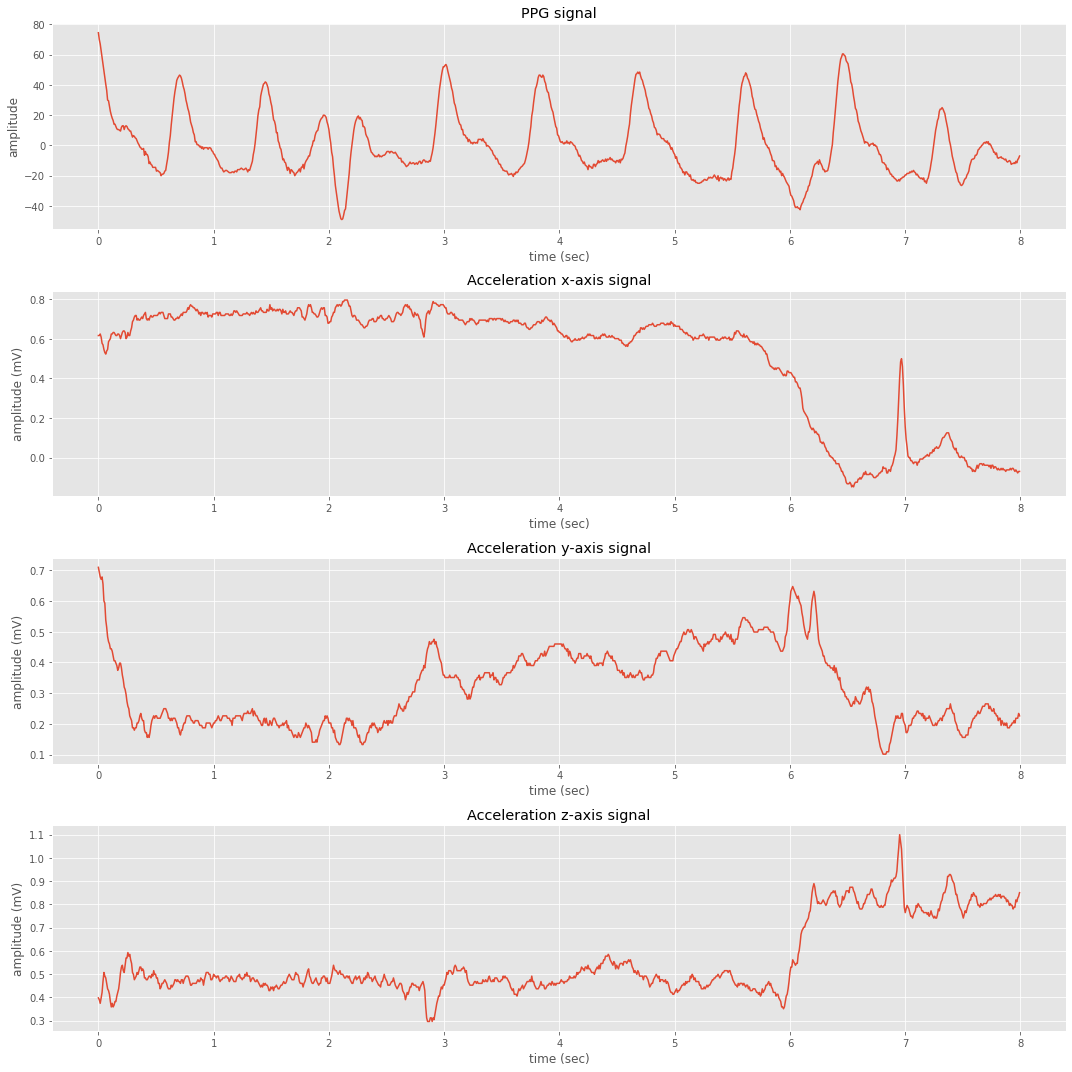

In [9]:
i=4
# plot (raw) time signals:
fig = plot_util.plot_raw_signals(
    ppg=dict_data_raw_window['ppg'][i],
    accx=dict_data_raw_window['accx'][i],
    accy=dict_data_raw_window['accy'][i],
    accz=dict_data_raw_window['accz'][i],
    fs=FS
)

group: data_01_type01
label: 151.59574468085106 BPM (2.526595744680851 Hz)


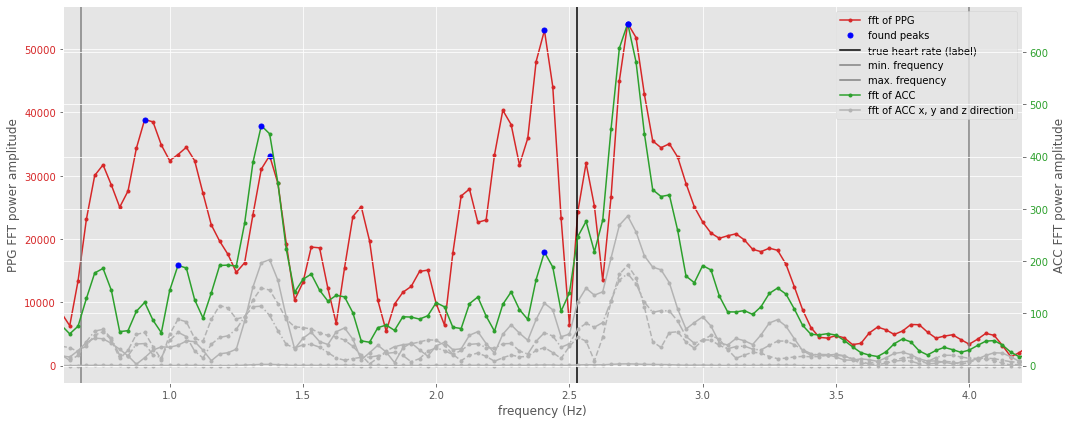

In [10]:
# plot a window data point
i = 100
fig = plot_util.plot_window_prediction(
    freqs=dict_data_raw_window['freqs'][i],
    ppg_fft=dict_data_raw_window['fft_ppg'][i],
    ppg_peaks_freqs=dict_features['peaks_freq_ppg'][i],
    ppg_peaks_pwr=dict_features['peaks_pwr_ppg'][i],
    ppg_label=labels[i],
    acc_fft=dict_data_raw_window['fft_acc_sum'][i],
    accx_fft=dict_data_raw_window['fft_accx'][i],
    accy_fft=dict_data_raw_window['fft_accy'][i],
    accz_fft=dict_data_raw_window['fft_accz'][i],
    acc_peaks_freqs=dict_features['peaks_freq_acc_sum'][i],
    acc_peaks_pwr=dict_features['peaks_pwr_acc_sum'][i],
    min_freq=min_freq,
    max_freq=max_freq
)
print(f'group: {groups[i]}')
print(f'label: {labels[i]} BPM ({labels[i]/60} Hz)')

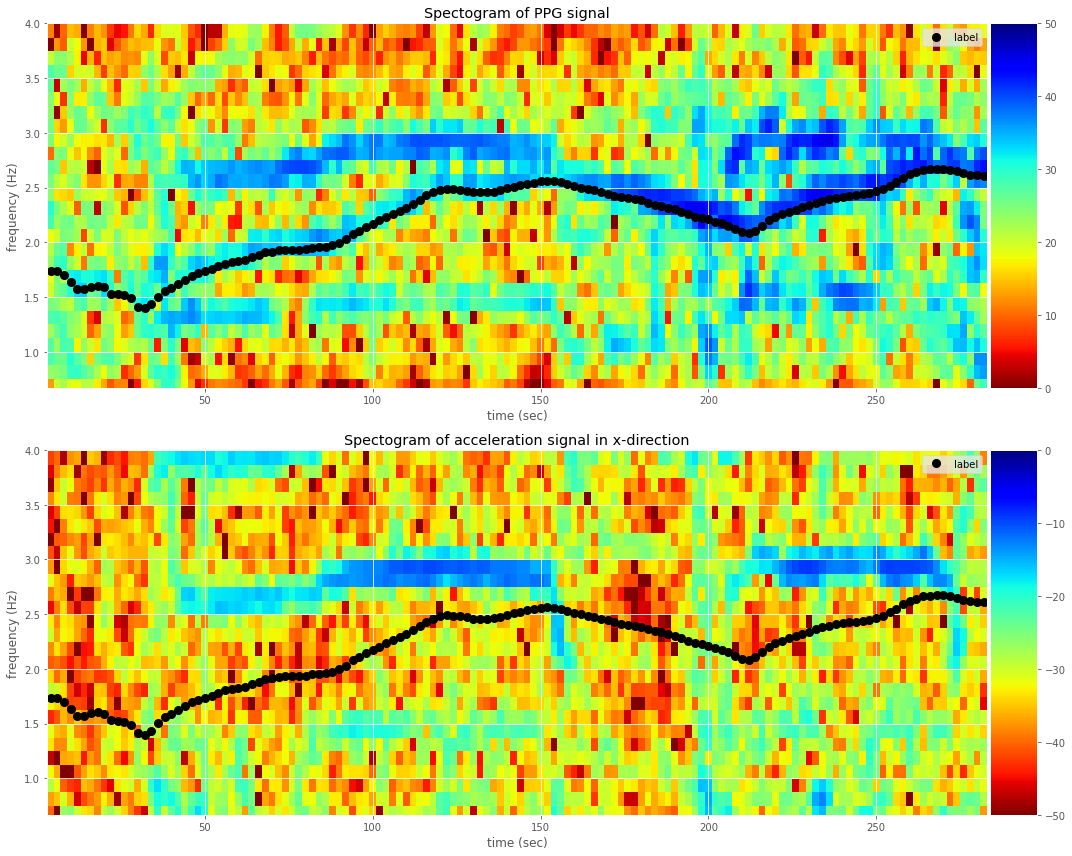

In [11]:
file = 'data_03_type02'
ppg_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file]['ppg'], pass_band=(min_freq, max_freq), fs=FS)
accx_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file]['accx'], pass_band=(min_freq, max_freq), fs=FS)
accy_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file]['accy'], pass_band=(min_freq, max_freq), fs=FS)
accz_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file]['accz'], pass_band=(min_freq, max_freq), fs=FS)
acc_abs, _ = etl.total_accelerometer_signal(accx=accx_raw_filtered, accy=accy_raw_filtered, accz=accz_raw_filtered, n_fft=n_fft)
fig = plot_util.plot_spectogram_sumarized(
    ppg=ppg_raw_filtered,
    acc=acc_abs,
    labels=labels_raw[f'ref{file[4:]}']/60,
    fs=FS,
    window_length=window_length,
    window_shift=window_shift,
    min_freq=min_freq,
    max_freq=max_freq
)

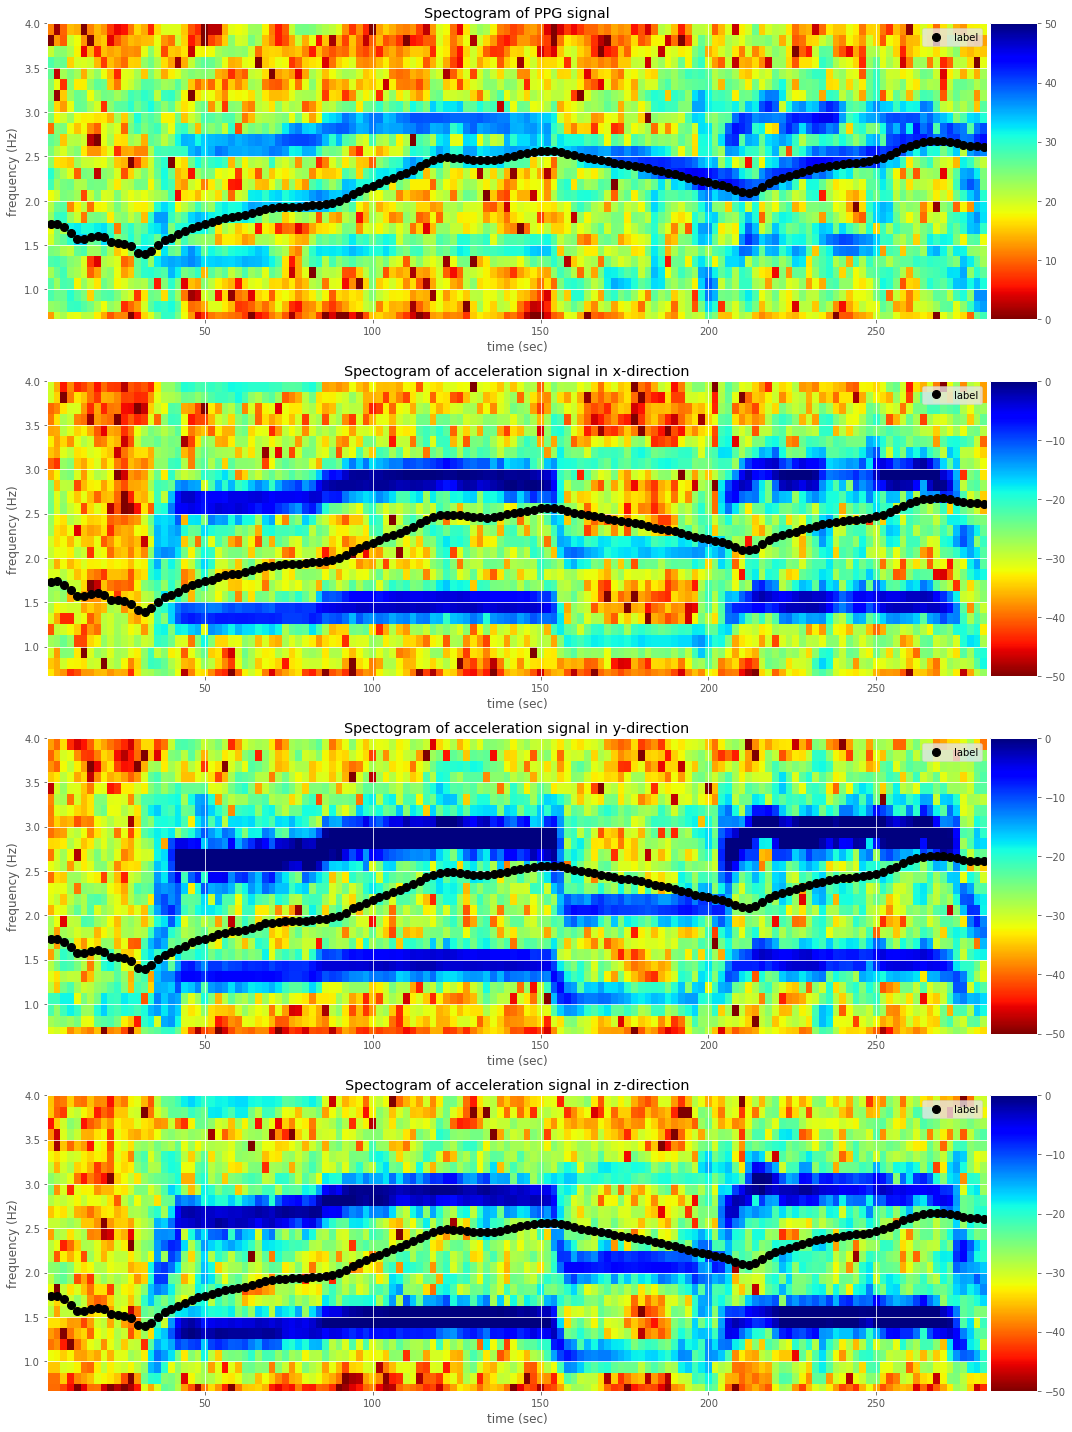

In [12]:
file = 'data_03_type02'
ppg_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file]['ppg'], pass_band=(min_freq, max_freq), fs=FS)
accx_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file]['accx'], pass_band=(min_freq, max_freq), fs=FS)
accy_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file]['accy'], pass_band=(min_freq, max_freq), fs=FS)
accz_raw_filtered = etl.bandpass_filter(signal=input_data_raw[file]['accz'], pass_band=(min_freq, max_freq), fs=FS)
fig = plot_util.plot_spectogram(
    ppg=ppg_raw_filtered,
    accx=accx_raw_filtered,
    accy=accy_raw_filtered,
    accz=accz_raw_filtered,
    labels=labels_raw[f'ref{file[4:]}']/60,
    fs=FS,
    window_length=window_length,
    window_shift=window_shift,
    min_freq=min_freq,
    max_freq=max_freq
)

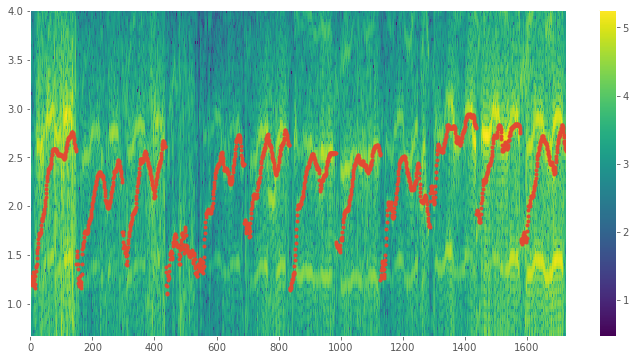

In [13]:
msk = (dict_data_raw_window['freqs']>=min_freq) & (dict_data_raw_window['freqs']<=max_freq)
a = dict_data_raw_window['fft_ppg']*msk
plt.pcolormesh(np.arange(len(labels)), dict_data_raw_window['freqs'][:, 22:129][0], np.log10(a[:, 22:129]).transpose(), shading='nearest')
plt.plot(np.arange(len(labels)), labels/60, '.')
plt.colorbar()

In [14]:
# def RunPulseRateAlgorithm(data_fl, ref_fl):
#     # Sample Frequency
#     fs = 125
#     # Window to calculate reference pulse rate
#     win_len = 8
#     # Difference between time windows
#     win_shift = 2    
       
#     reg, scores = load_regressor()
#     targets, features, sigs, subs = load_data(data_fl, ref_fl)
#     error, confidence = [], []
#     for i,feature in enumerate(features):
#         est = reg.predict(np.reshape(feature, (1, -1)))[0]
        
#         # Calculate confidence
#         ppg, accx, accy, accz = sigs[i]
        
#         ppg = bandpass_filter(ppg)        
#         accx = bandpass_filter(accx)
#         accy = bandpass_filter(accy)
#         accz = bandpass_filter(accz)        
        
#         n = len(ppg) * 3
#         freqs = np.fft.rfftfreq(n, 1/fs)
#         fft = np.abs(np.fft.rfft(ppg,n))
#         fft[freqs <= 40/60.0] = 0.0
#         fft[freqs >= 240/60.0] = 0.0
    
#         # Max magnitude frequency
#         est_fs = est / 55.0
#         fs_win = 30  / 60.0
#         fs_win_e = (freqs >= est_fs - fs_win) & (freqs <= est_fs +fs_win)
#         conf = np.sum(fft[fs_win_e])/np.sum(fft)
        
#         error.append(np.abs((est-targets[i])))
#         confidence.append(conf)
#     return np.array(error), np.array(confidence)

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 